In [8]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

## 1. Synthetic data generation

### 1.1 Linear data

In [9]:
def true_fun(x, a=np.pi, b=0, f=np.sin):
    x = np.atleast_1d(x)[:]
    a = np.atleast_1d(a)
    
    if f is None: f = lambda x: x
    x = np.sum([ai * np.power(x, i + 1) for i, ai in enumerate(a)], axis=0)

    return f(x + b)

def noises(shape , noise_power):
    return np.random.randn(*shape) * noise_power

def dataset(a, b, f = None,  N = 250, x_max = 1, noise_power = 0, random_x = True,  seed = 42):
    np.random.seed(seed)
    
    if random_x:
        x = np.sort(np.random.rand(N)) * x_max    
    else:
        x = np.linspace(0, x_max, N)
    
    y_true = np.array([])
    
    for f_ in np.append([], f):
        y_true = np.append(y_true, true_fun(x, a, b, f_))
    
    y_true = y_true.reshape(-1, N).T
    y = y_true + noises(y_true.shape, noise_power)

    return y, y_true, np.atleast_2d(x).T

In [2]:
linear_data_x = np.linspace(0, 1, 50)
linear_data_y = np.linspace(0, 1, 50)

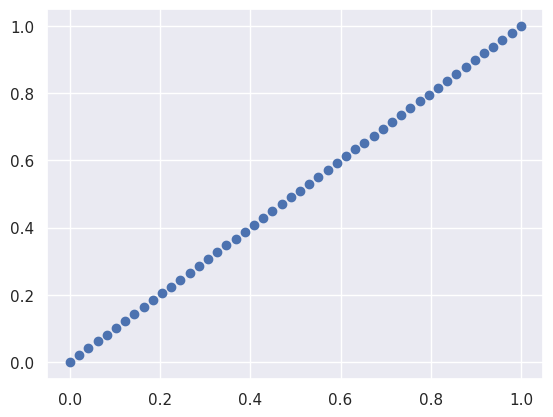

In [3]:
plt.scatter(x=linear_data_x, y=linear_data_y)

In [4]:
noisy_x = linear_data_x + np.random.uniform(-1, 1, 50)
noisy_y = linear_data_y + np.random.uniform(-1, 1, 50)
noisy_x

array([ 0.56189086, -0.68796794,  0.12004734,  0.54930948, -0.86642996,
       -0.03420081,  0.25200311,  0.3982751 ,  1.03805437,  0.25605841,
        0.75221521,  0.5361251 , -0.70085571, -0.33851995,  0.62376335,
       -0.4926174 , -0.14071628,  1.28643008,  0.20828036,  0.84748417,
        0.25871078, -0.07730187,  0.30946721,  0.15024606,  0.65960559,
       -0.40105275,  0.64274096,  0.42987652,  0.17281717,  1.21399259,
        0.43708682,  0.99907635,  1.2634007 ,  1.22497953,  1.38985883,
        0.06987585,  0.02338345, -0.04283212,  1.4977367 ,  0.47379994,
        1.0534479 ,  1.54241051,  0.48300329,  1.27877458, -0.02954016,
        0.11963851,  0.57245553,  1.31687174,  0.26450199,  1.76489721])

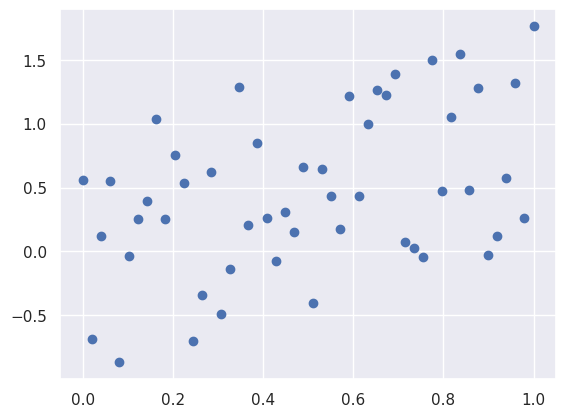

In [5]:
plt.scatter(x=linear_data_x, y=noisy_x)

In [6]:
intervals = np.sort(np.random.uniform(0, 1, 50))
data = np.concatenate([np.linspace(start, stop, 50) for start, stop in zip(intervals[:-1], intervals[1:])])

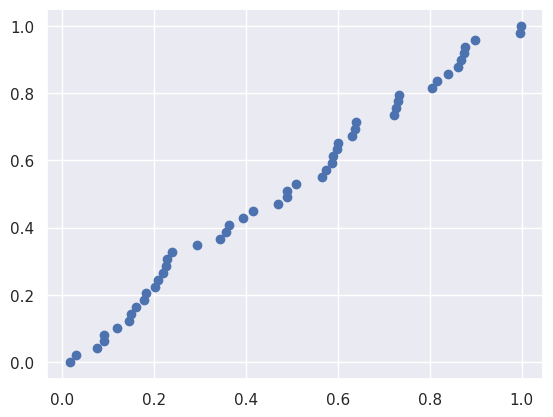

In [7]:
plt.scatter(x=intervals, y=linear_data_x)